In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np

In [3]:
omp = 1
mpi = 4

# DFT analysis of GaAs

This notebook contains the analysis of the GaAs (__without__ SO interaction) performed with QuantumESPRESSO. In particular

* GS convergence for the energy cutoff, the number of kpoints and the equilibrium lattice constant
* Plot of the band structure along a path and determination of the value of the scissor nedded to set the gap to 1.42 eV, that correspond
   to the experimental value at 300 K.
* NSCF computations performed on various kpoints samplings, needed for the subsequent RT analysis.
* Analysis of the Dos
* Analysis of the JDos

## GS convergence analysis

In [4]:
run_dir = 'GS_convergence'

We define a basic input object for scf calculations

In [5]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2'},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

### Convergence tests on the energy cutoff of the wavefunctions

We perform a first seek_convergence procedure using the cutoff energy of the wave functions as free parameter.
In this case we set the kpoints sampling on a grid 6,6,6

In [6]:
kvalue = 6
inp.set_kpoints(type='automatic',points=[kvalue,kvalue,kvalue])

We start with the value of 40 Ry

In [7]:
ecut = [10*i for i in range(4,10)]
ecut

[40, 50, 60, 70, 80, 90]

In [8]:
ecut_conv = D.Dataset(run_dir=run_dir)

In [9]:
code = C.QeCalculator(omp=omp,mpi=mpi)
code.global_options()

Initialize a parallel QuantumESPRESSO calculator with scheduler direct


{'omp': 1,
 'mpi': 4,
 'mpi_run': 'mpirun -np',
 'executable': 'pw.x',
 'scheduler': 'direct',
 'multiTask': True,
 'skip': True,
 'verbose': True,
 'IO_time': 5}

In [10]:
for e in ecut:
    idd = {'ecut' : e, 'k' : kvalue}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_energy_cutoff(e)
    ecut_conv.append_run(id=idd,input=inp,runner=code)

We use a postProcessing function to extract the total energy from the results and run a seek_convergence

In [11]:
ecut_conv.set_postprocessing_function(D.QE_get_energy)

In [12]:
ecut_conv.seek_convergence(rtol=1e-5)

Fetching results for id " {'ecut': 40, 'k': 6} "
Create the sub-directory 'GS_convergence'
run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp ecut_40-k_6.in > ecut_40-k_6.log
run0_is_running: True 
Job completed
Fetching results for id " {'ecut': 50, 'k': 6} "
run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp ecut_50-k_6.in > ecut_50-k_6.log
run0_is_running: True 
Job completed
Convergence reached in Dataset "Dataset" for id " {'ecut': 40, 'k': 6} "


({'ecut': 40, 'k': 6}, -12.35957313057563)

As a further convergence check on ecut_conv we compute the value of the direct gap.

First we perform the scf computations for the all the values of ecut since we need them as
source directory in the nscf calculations

In [18]:
code.update_global_options(multiTask=False)
ecut_conv.run()
code.update_global_options(multiTask=True)

Skip the run of ecut_40-k_6
Skip the run of ecut_50-k_6
Skip the run of ecut_70-k_6
Skip the run of ecut_80-k_6
run 2 command: cd GS_convergence; mpirun -np 4 pw.x -inp ecut_60-k_6.in > ecut_60-k_6.log
run 5 command: cd GS_convergence; mpirun -np 4 pw.x -inp ecut_90-k_6.in > ecut_90-k_6.log
run2_is_running: True 
Job completed
run5_is_running: True 
Job completed


Then we run the nscf computations at $\Gamma$ with the empty bands to compute the gap.

Since the various runs use different source_dir we need to use different calculators

In [19]:
gaps_data = D.Dataset(run_dir=run_dir)
num_bands = 6
klist = [[0.0,0.0,0.0,1.0]]

calcs = []
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)
inp.set_kpoints(type='tpiba',klist=klist)
for ind,e in enumerate(ecut):
    source = 'GS_convergence/ecut_%s-k_%s.save'%(e,kvalue)
    calcs.append(C.QeCalculator(omp=omp,mpi=mpi))
    inp.set_energy_cutoff(e)
    idd = {'ecut': e, 'bands' : num_bands, 'sampling' : 'gamma'} 
    pref = D.name_from_id(idd)
    inp.set_prefix(pref)
    gaps_data.append_run(id=idd,input=inp,runner=calcs[ind],source_dir = source, multiTask=False)

Initialize a parallel QuantumESPRESSO calculator with scheduler direct
Initialize a parallel QuantumESPRESSO calculator with scheduler direct
Initialize a parallel QuantumESPRESSO calculator with scheduler direct
Initialize a parallel QuantumESPRESSO calculator with scheduler direct
Initialize a parallel QuantumESPRESSO calculator with scheduler direct
Initialize a parallel QuantumESPRESSO calculator with scheduler direct


In [20]:
gaps_data.set_postprocessing_function(D.QE_get_gap)

In [21]:
gaps_data.run()

Copy source_dir GS_convergence/ecut_40-k_6.save in the GS_convergence/bands_6-ecut_40-sampling_gamma.save
run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp bands_6-ecut_40-sampling_gamma.in > bands_6-ecut_40-sampling_gamma.log
run0_is_running: True 
Job completed
Copy source_dir GS_convergence/ecut_50-k_6.save in the GS_convergence/bands_6-ecut_50-sampling_gamma.save
run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp bands_6-ecut_50-sampling_gamma.in > bands_6-ecut_50-sampling_gamma.log
run0_is_running: True 
Job completed
Copy source_dir GS_convergence/ecut_60-k_6.save in the GS_convergence/bands_6-ecut_60-sampling_gamma.save
run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp bands_6-ecut_60-sampling_gamma.in > bands_6-ecut_60-sampling_gamma.log
run0_is_running: True 
Job completed
Copy source_dir GS_convergence/ecut_70-k_6.save in the GS_convergence/bands_6-ecut_70-sampling_gamma.save
run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp bands_6-ecut_70-sampling

{0: 0.3762199736873074,
 1: 0.3754402515931307,
 2: 0.3758290800361329,
 3: 0.3757522650136734,
 4: 0.37566685972132113,
 5: 0.37519438862493165}

To be safe we choose

In [22]:
ecut_conv = 60

### Convergence tests on the number of kpoints for gs density

In [23]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_energy_cutoff(ecut_conv)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

In [24]:
kvalue_conv = D.Dataset(run_dir=run_dir)

In [25]:
kvalues = [6,7,8]

In [26]:
for k in kvalues:
    idd = {'ecut' : ecut_conv, 'k' : k}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,k])
    kvalue_conv.append_run(id=idd,input=inp,runner=code)

In [27]:
kvalue_conv.set_postprocessing_function(D.QE_get_energy)

In [30]:
kvalue_conv.seek_convergence(rtol=1e-4)

Fetching results for id " {'ecut': 60, 'k': 6} "
Fetching results for id " {'ecut': 60, 'k': 7} "
Convergence reached in Dataset "Dataset" for id " {'ecut': 60, 'k': 6} "


({'ecut': 60, 'k': 6}, -12.35965057696348)

We choose k = 6 that guarantees convergence at the order of 1meV

In [31]:
k_conv = 6

### Calculation of  the equilibrium lattice constants

In [32]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'automatic', 'values': ([6, 6, 6], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [33]:
lat_conv = D.Dataset(run_dir=run_dir)

In [34]:
lat0 = 10.5
scale = 5e-3
deltas = [i for i in range(-3,4)]

In [35]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])

In [36]:
for delta in deltas:
    idd = {'lat_delta' : delta}
    inp.set_prefix(D.name_from_id(idd))
    lat = lat0*(1+delta*scale)
    inp.set_lattice(2,celldm1=lat)
    lat_conv.append_run(id=idd,input=inp,runner=code,multiTask=False)

In [37]:
lat_conv.set_postprocessing_function(D.QE_get_energy)

In [38]:
results = lat_conv.run()

run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_-3.in > lat_delta_-3.log
run 1 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_-2.in > lat_delta_-2.log
run 2 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_-1.in > lat_delta_-1.log
run 3 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_0.in > lat_delta_0.log
run 4 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_1.in > lat_delta_1.log
run 5 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_2.in > lat_delta_2.log
run 6 command: cd GS_convergence; mpirun -np 4 pw.x -inp lat_delta_3.in > lat_delta_3.log
run0_is_running: True 
Job completed
run1_is_running: True 
Job completed
run2_is_running: True 
Job completed
run3_is_running: True 
Job completed
run4_is_running: True 
Job completed
run5_is_running: True 
Job completed
run6_is_running: True 
Job completed


We perform a quadratic fit of data

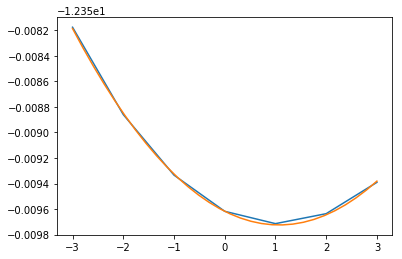

In [39]:
res = [results[i] for i in range(len(deltas))]
coeffs = np.polyfit(deltas,res,2)
values_fit = np.linspace(deltas[0],deltas[-1],30)
res_fit = [coeffs[0]*x**2+coeffs[1]*x+coeffs[2] for x in values_fit]
plt.plot(deltas,res)
plt.plot(values_fit,res_fit)

In [40]:
delta_eq = -coeffs[1]/(2*coeffs[0])
lat_eq = lat0*(1+delta_eq*scale)
lat_eq

10.556443308022324

This is the value of the equilibrium lattice constants. So to summarize

In [79]:
ecut_conv = 60
k_conv = 6
lat_eq = 10.556

We perform a last scf computation for the converged system, that will be used as starting point for the nscf ones

In [80]:
prefix = 'gs_converged'

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(prefix)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'gs_converged'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'automatic', 'values': ([6, 6, 6], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [81]:
code.run(run_dir=run_dir,inputs=[inp],names=[prefix])

run 0 command: cd GS_convergence; mpirun -np 4 pw.x -inp gs_converged.in > gs_converged.log
run0_is_running: True 
Job completed


{'output': ['GS_convergence/gs_converged.save/data-file-schema.xml']}

# Analysis of the band structure

In [82]:
run_dir = 'QE_bands'

We compute the band structure along a path. We use the converged energy_cutoff and lattice parameters.

In [83]:
hsp = U.high_sym_fcc
klist = U.build_kpath(hsp['L'],hsp['G'],hsp['X'],hsp['K'],hsp['G'],numstep=30)
klist

[[0.5, 0.5, 0.5, 30],
 [0.0, 0.0, 0.0, 30],
 [0.0, 0.0, 1.0, 30],
 [0.0, 1.0, 1.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [84]:
pref = 'bands' 

inp = I.PwInput()
inp.set_bands(8,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bands'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.5, 0.5, 0.5, 30],
   [0.0, 0.0, 0.0, 30],
   [0.0, 0.0, 1.0, 30],
   [0.0, 1.0, 1.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [85]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir='GS_convergence/gs_converged.save')

Create the sub-directory 'QE_bands'
Copy source_dir GS_convergence/gs_converged.save in the QE_bands/bands.save
run 0 command: cd QE_bands; mpirun -np 4 pw.x -inp bands.in > bands.log
run0_is_running: True 
run0_is_running: True 
Job completed


In [86]:
bands = U.BandStructure.from_Pw(result['output'][0],hsp,set_gap=1.42)

Apply a scissor of 0.9547660195971782 eV


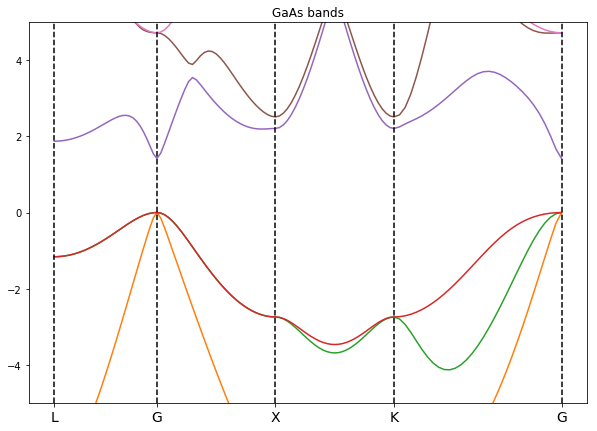

In [87]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('GaAs bands')
plt.ylim(-5,5)
bands.plot(plt,selection=[i for i in range(0,7)])

It is useful also to display the band structure evidencing the region around $\Gamma$ that is sampled for the RT analysis

In [88]:
hs_positions = bands.get_high_sym_positions()
hs_positions

(['G', 'G', 'X', 'L', 'K'],
 [0.8660254037844385,
  4.28023896615753,
  1.8660254037844377,
  0.0,
  2.866025403784435])

In [89]:
kspan = 0.05 #in unit of 2pi/alat
k0 = hs_positions[1][0]
k0

0.8660254037844385

(0.0, 1.864)

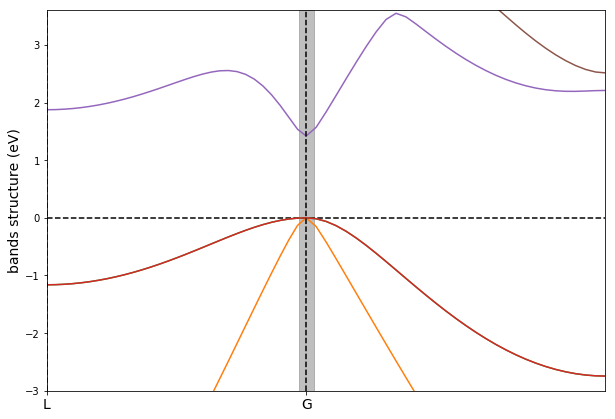

In [90]:
fig, ax = plt.subplots(figsize=(10, 7))
bands.plot(plt)
ax.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
plt.ylim(-3,3.6)
plt.ylabel('bands structure (eV)',size=14)
plt.hlines(0.,0.,2,linestyles='--')
plt.xlim(0.,1.864)

## NSCF computation on various grids

We perform nscf computations on grids of various dimensions and type. These computations will be the starting points for various
RT analysis, to the effects of the kpoints sampling in the real-time reponse of the systems. 

All the computations share the same scf input. The common parameters are

In [91]:
run_dir = 'NSCF'

In [92]:
ecut_conv = 60
k_conv = 6
lat_eq = 10.556
source_dir = 'GS_convergence/gs_converged.save'
num_bands = 8

In [93]:
code = C.QeCalculator(omp=omp,mpi=mpi)

Initialize a parallel QuantumESPRESSO calculator with scheduler direct


The basic input file is given by

In [94]:
inp = I.PwInput()
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

### Regular grid

In [95]:
kpoints = 8 #20

In [96]:
idd = {'bnds' : num_bands, 'kpoints' : kpoints}
pref = D.name_from_id(idd)
inp.set_kpoints(type='automatic',points=[kpoints,kpoints,kpoints])
inp.set_prefix(pref)
#inp

In [97]:
result_reg = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_reg

Create the sub-directory 'NSCF'
Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_8-kpoints_8.save
run 0 command: cd NSCF; mpirun -np 4 pw.x -inp bnds_8-kpoints_8.in > bnds_8-kpoints_8.log
run0_is_running: True 
Job completed


{'output': ['NSCF/bnds_8-kpoints_8.save/data-file-schema.xml']}

### Gamma

In [98]:
klist = [[0.0,0.0,0.0,1.0]]

In [99]:
idd = {'bnds' : num_bands, 'sampling' : 'gamma'} 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bnds_8-sampling_gamma'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba', 'values': [[0.0, 0.0, 0.0, 1.0]]},
 'cell_parameters': {}}

In [100]:
result_gamma = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_gamma

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_8-sampling_gamma.save
run 0 command: cd NSCF; mpirun -np 4 pw.x -inp bnds_8-sampling_gamma.in > bnds_8-sampling_gamma.log
run0_is_running: True 
Job completed


{'output': ['NSCF/bnds_8-sampling_gamma.save/data-file-schema.xml']}

In [101]:
data = P.PwParser(result_gamma['output'][0])

Parse file : NSCF/bnds_8-sampling_gamma.save/data-file-schema.xml


In [102]:
data.get_evals(set_gap=1.42)

Apply a scissor of 0.954766022712177 eV


array([[-1.29871374e+01, -3.46652840e-09, -1.92620675e-09,
         0.00000000e+00,  1.42000000e+00,  4.72372664e+00,
         4.72372664e+00,  4.72372666e+00]])

### Random grid close to Gamma

In [103]:
import random as rand
num_kpoints = 100 #100 #50
k_span = 0.05
#k_span = 0.07 # extended_region
#k_span = 0.03 # reduced_region
weight = [1.]

In [104]:
klist = []
klist.append([0.,0.,0.]+weight) #we include Gamma
for n in range(num_kpoints-1):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + weight
    klist.append(k_rand)

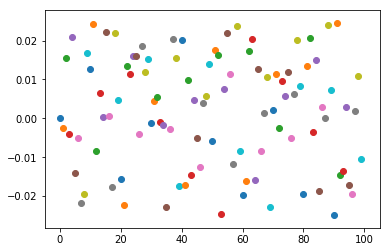

In [105]:
for ind,k in enumerate(klist):
    plt.scatter(ind,k[0])

In [106]:
idd = {'bnds' : num_bands, 'kpoints' : num_kpoints, 'sampling' : 'random_close_Gamma_kspan0.05'}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [107]:
result_random = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir,skip=False)
result_random

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save
run 0 command: cd NSCF; mpirun -np 4 pw.x -inp bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.in > bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.log
run0_is_running: True 
run0_is_running: True 
Job completed


{'output': ['NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml']}

In [108]:
data = P.PwParser(result_random['output'][0])

Parse file : NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml


In [109]:
data.kpoints[28]

[0.01186218, 0.006219309999999999, -0.01176368]

### Single kpoint close to $\Gamma$ (old from the spin notebook)

We consider one kpoint close to $\Gamma$ but outside the high symmetry directions of the lattice

In [32]:
#klist = [[0.1,0.03,0.0,1.0]] # a point without simmetries. eps_cv around 2.15 eV anad eps_cc' = 7 meV
klist = [[-0.0247738, 0.00762269, 0.02365302,1.0]]  # kpoin num 31. Correspond to the max cc' oscillation in Kpump region
#klist = [[-0.01655783, 0.00728803, 0.02452443,1.0]] # kpoin num 28. Correspond to the a 'medium' cc' oscillation with 0.602 meV

In [33]:
idd = {'bnds' : num_bands, 'sampling' : '1k-maxfreq'}   # '1k-nosym'  '1k-maxfreq' '1k-mediumfreq' 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
print(pref)
inp

bnds_16-sampling_1k-maxfreq


{'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'atomic_species': {'As': ['1.0', 'As_rel.pz-rrkj3.UPF'],
  'Ga': ['1.0', 'Ga_rel.pz-rrkj3.UPF']},
 'cell': {},
 'cell_parameters': {},
 'control': {'calculation': "'nscf'",
  'prefix': "'bnds_16-sampling_1k-maxfreq'",
  'pseudo_dir': "'../pseudos'",
  'verbosity': "'high'"},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'kpoints': {'type': 'tpiba',
  'values': [[-0.0247738, 0.00762269, 0.02365302, 1.0]]},
 'system': {'celldm(1)': 10.475,
  'ecutwfc': 80,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'lspinorb': '.true.',
  'nat': '2',
  'nbnd': 16,
  'noncolin': '.true.',
  'ntyp': '2',
  'occupations': "'fixed'"}}

In [34]:
result_1knosym = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_1knosym

The folder NSCF/bnds_16-sampling_1k-maxfreq.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the computation for input bnds_16-sampling_1k-maxfreq
Job completed


{'output': ['NSCF/bnds_16-sampling_1k-maxfreq.save/data-file-schema.xml']}

In [35]:
data = P.PwParser(result_1knosym['output'][0])

Parse file : NSCF/bnds_16-sampling_1k-maxfreq.save/data-file-schema.xml


In [36]:
eigen = data.get_evals() # we cannot set_gap here because we do not know the gap value at this k point
eigen

array([[-1.32142141e+01, -1.32142138e+01, -4.03867061e-01,
        -4.02224724e-01, -7.72876570e-02, -7.46899354e-02,
        -1.78911000e-04,  0.00000000e+00,  9.85594580e-01,
         9.86543743e-01,  3.61373221e+00,  3.61460140e+00,
         3.81377621e+00,  3.81397949e+00,  3.82813744e+00,
         3.82864863e+00]])

There is energy difference in the spin up and spin down conduction bands

In [37]:
1e3*(eigen[0][9]-eigen[0][8])

0.9491628183351253

The gaps associated to this kpoint are

In [38]:
scissor = 0.5456 # we need to add the scissor at gamma
g1 = eigen[0][8]+scissor-eigen[0][7]
g2 = eigen[0][9]+scissor-eigen[0][7]
g3 = eigen[0][8]+scissor-eigen[0][6]
g4 = eigen[0][9]+scissor-eigen[0][6]
gmean = (g1+g2+g3+g4)/4
gmean

1.5317586166901225

## Analysis of the Dos

We can compare the Dos associated to the regular grid sampling with the one related to the random samplings.

In [111]:
dos = U.Dos.from_Pw('NSCF/bnds_8-kpoints_8.save/data-file-schema.xml',set_gap=1.42,eta=0.05,label='reg',minVal=-4,maxVal=4)

Apply a scissor of 0.9547660381861632 eV


In [112]:
dos.append_fromPw('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml',label='rand100',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.954766022712177 eV


In [114]:
#dos.append_fromPw('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml',label='rand100',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)
#dos.append_fromPw('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml',label='rand50',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)
#dos.append_fromPw('NSCF/bnds_16-kpoints_200-sampling_random.save/data-file-schema.xml',label='rand200',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

We can compare all the dos

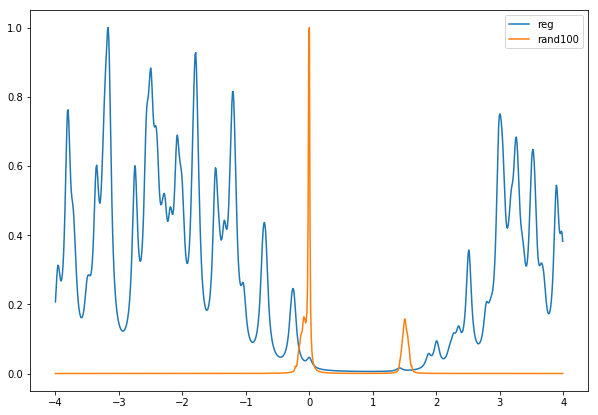

In [119]:
fig, ax = plt.subplots(figsize=(10, 7))
dos.plot(plt,rescale=True)
plt.legend(loc='best')

## Analysis of the JDos

We analyze the JDos assciated to the $v \rightarrow c$ transitions including the 3 valence bands that are quasi degenerate
close to $\Gamma$ in absence of the SOC and the first conduction band. Adding the second conduction band gives rise to
a peak aroung 4.8 eV that is much higher than the pump energy.

In [4]:
r_100 = P.PwParser('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml')

Parse file : NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml


In [5]:
weights_100 = r_100.weights

In [6]:
transitions_100 = r_100.get_transitions(set_gap=1.42,initial=[1,2,3],final=[4])

Apply a scissor of 0.954766022712177 eV


In [28]:
jdos = U.Dos()
jdos.append_fromPwData(transitions_100,weights_100,minVal=0,maxVal=2,eta=4e-3,label='$N_k$=100')

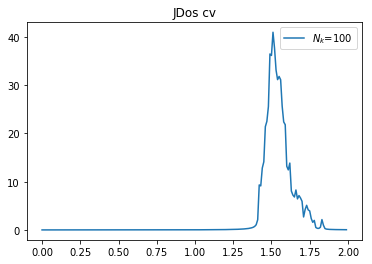

In [29]:
jdos.plot(plt)
plt.title('JDos cv')
plt.legend()

We include also the energetic profile of the pump. To do so we consider the analytic form of the QSIN pump and perform its FT

In [30]:
epump = 1.5 # eV
hplanck = U.Planck_ev_ps*1e3 # Planck constant in ev*fs
nupump = epump/hplanck # in fs^-1

width = 30 # fs (it is an estimate since we set 100 fs for the intensity)
t0 = 3*width

T = 2000 # lenght of the time interval
dt = 0.01 # resolution of time sampling
N = int(T/dt) # number of sampled points

time = np.linspace(0,T,N)
field = np.sin(2.*np.pi*nupump*time)*np.exp(-0.5*((time-t0)/width)**2) 

In [31]:
freqs = np.fft.fftfreq(N, d=dt)
fplus = freqs[0:int(N/2)]
fourier = np.fft.fft(field)
fourierplus = fourier[0:int(N/2)]
fabs = np.sqrt(fourierplus.real**2+fourierplus.imag**2)
fabs = fabs/max(fabs)

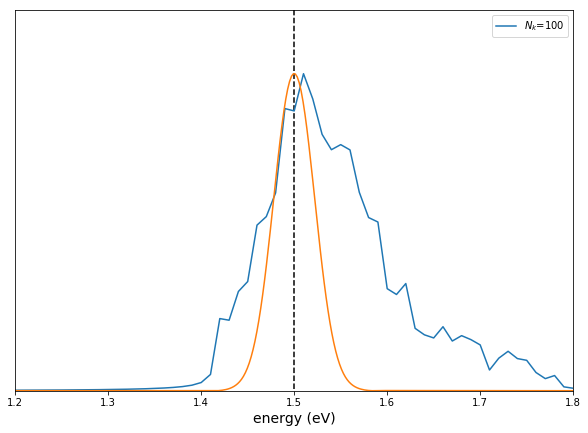

In [32]:
fig, ax = plt.subplots(figsize=(10, 7))

jdos.plot(plt,rescale=True)
plt.plot(hplanck*fplus,fabs)
#plt.title('JDos cv')
plt.vlines(1.5,-2,2,linestyles='--')
plt.yticks([])
plt.xlabel('energy (eV)',size=14)
plt.xlim(1.2,1.8)
plt.ylim(0,1.2)
plt.legend()

## Estimate of the FID time scale

We compute an estimate of the time profile of the signal by computing the weighted average
of a cosine function using the JDOS$_{cv}$ as weight function

In [33]:
from scipy import integrate as I

Text(0.5,0,'time (fs)')

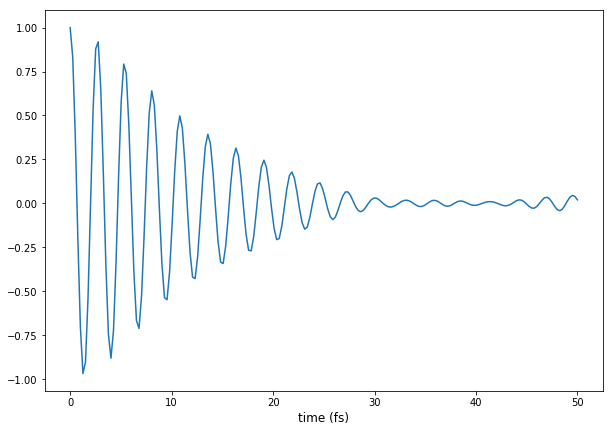

In [34]:
eng = jdos.dos[0][0]
values= jdos.dos[0][1]

norm = I.simps(y=values,x=eng)

nus = eng/(U.Planck_ev_ps*1e3) # in fs^-1
omegas = 2.0*np.pi*nus
tvals = np.linspace(0,50,200) # 200 point for a range of 50 fs

res = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
res100 = np.array(res)

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(tvals,res)
plt.xlabel('time (fs)',size=12)

comment on the oscillatory behavior?